# Modelling & Evaluation

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

#BASEDIR = Path("/store/projects/ddm-ws2022/vorlesung/")

/home/lbader/.conda/envs/py310-dm-tf-cloned/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Functions to visualize the decision boundaries

In [2]:
def plot_kmeans(model):
    X = X_train  # we only take the first two features.
    y = y_train

    def make_meshgrid(x, y, h=.02):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return xx, yy

    def plot_contours(ax, clf, xx, yy, **params):
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
        return out

    clf = KMeans(n_clusters=5, random_state=0, n_init=10).fit(X_train)

    fig, ax = plt.subplots(figsize=(8, 6))
    # Title for the plot
    title = f"k-means clustered data with {clf.n_clusters} clusters"
    # Set-up grid for plotting
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    # Use a lighter colormap, e.g., 'Pastel1' for the contours
    plot_contours(ax, clf, xx, yy, cmap='Paired', alpha=0.6)
    # Scatter the data points with cluster labels
    ax.scatter(X0, X1, c=clf.labels_, cmap='Paired', s=30, edgecolors='k')
    # Mark the centroids
    ax.scatter(clf.cluster_centers_[:, 0], clf.cluster_centers_[:, 1], 
               marker='*', s=150, c='gold', edgecolors='black', label='Centroid')
    
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    plt.show()

In [3]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_moons

def plot_kmeans_moons(model, X):
    def make_meshgrid(x, y, h=0.02):
        x_min, x_max = x.min() - 0.5, x.max() + 0.5
        y_min, y_max = y.min() - 0.5, y.max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return xx, yy

    def plot_contours(ax, clf, xx, yy, **params):
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
        return out

    # Create a meshgrid for the plot
    X0, X1 = X[:, 0], X[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(8, 6))
    title = f"k-means clustered data with {model.n_clusters} clusters"

    # Plot decision boundaries
    plot_contours(ax, model, xx, yy, cmap='Pastel1', alpha=0.6)

    # Scatter the data points with cluster labels
    ax.scatter(X0, X1, c=model.labels_, cmap='Paired', s=30, edgecolors='k')

    # Mark the centroids
    ax.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], 
               marker='*', s=150, c='gold', edgecolors='black', label='Centroid')

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    ax.legend()
    plt.show()

# Generate moon-shaped data
X_2, y_2 = make_moons(200, noise=0.05, random_state=0)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=0, n_init=10).fit(X_2)

## k-means Clustering

### Normalizing your data

You do have to normalize your data so all the features are within the same range, whenever you do anything that involves Euclidean space, which $k$-means does.

In [4]:
from sklearn.datasets import make_blobs
X, y = make_blobs(200, 2, centers=5, random_state=2, cluster_std=0.8)

In [5]:
# Normalize the data
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
X = scl.fit_transform(X)

In [6]:
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, random_state=101)

/tmp/ipykernel_747385/3590641527.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[0].scatter(X_train[:, 0], X_train[:, 1], s=50, cmap='Set1')
/tmp/ipykernel_747385/3590641527.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axes[1].scatter(X_test[:, 0], X_test[:, 1], s=50, cmap='Set1')


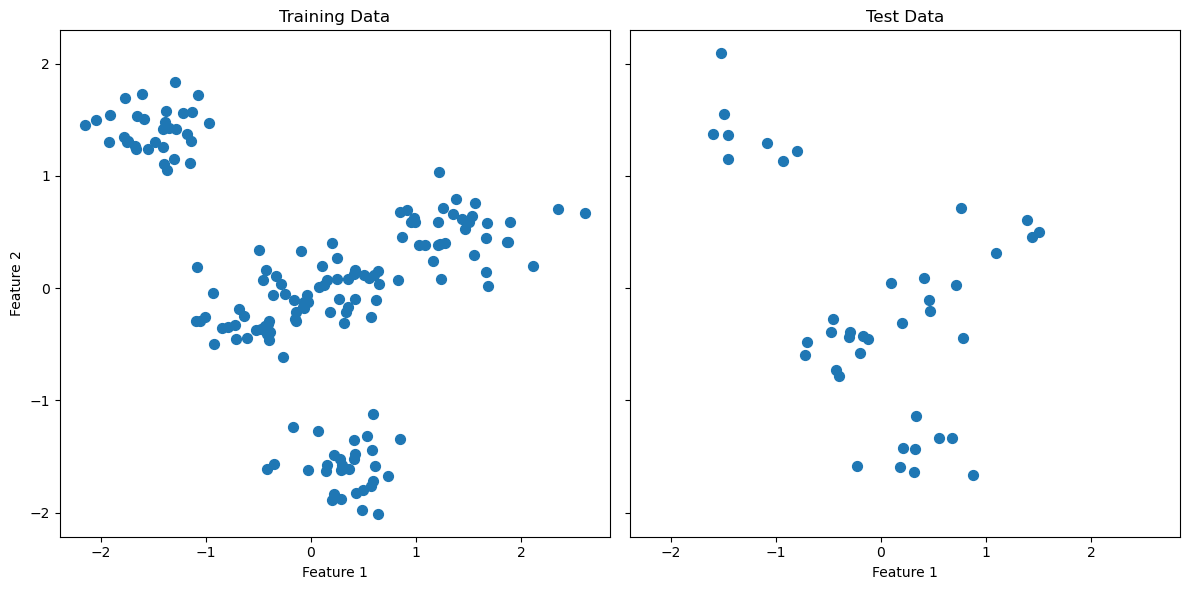

In [7]:
# Create subplots for training and test data
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

# Plot for training data
axes[0].scatter(X_train[:, 0], X_train[:, 1], s=50, cmap='Set1')
axes[0].set_title("Training Data")
axes[0].set_xlabel("Feature 1")
axes[0].set_ylabel("Feature 2")

# Plot for test data
axes[1].scatter(X_test[:, 0], X_test[:, 1], s=50, cmap='Set1')
axes[1].set_title("Test Data")
axes[1].set_xlabel("Feature 1")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Another common challenge with $k$-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.

### Selection of the optimal number of clusters

From the above visualization, we can see that the optimal number of clusters should be around 4/5. But visualizing the data alone cannot always give the right answer. Hence we demonstrate the following steps.
We now define the following internal Indices:

**1. Distortion**: (average minimum distance to cluster center). Typically, the Euclidean distance metric is used.

**2. Inertia**: (sum of squared distances to cluster centers).

**3. Average Silhouette**: It measures how similar an object is to its own cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its cluster and poorly matched to neighboring clusters.

**3. Davies-Bouldin Index**: Measuring the average similarity between each cluster and its most similar counterpart, where lower values indicate better clustering. Similarity is defined as the ratio between inter-cluster and intra-cluster distances

We iterate the values of k from 2 to 10 and calculate the values of distortions for each value of k and calculate the distortion and inertia for each value of k in the given range.


In [8]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

# Initialize lists and range for K
distortions = []
inertias = []
silhouette_scores = []
davies_bouldin_scores = []  # Add Davies-Bouldin list
mapping1 = {}
mapping2 = {}
K = range(2, 11)  # Silhouette Score and Davies-Bouldin Index are undefined for K=1

for i in K:
    # Fit KMeans model
    model = KMeans(n_clusters=i, n_init=10, random_state=42).fit(X)
    
    # Compute distortions (average minimum distance to cluster center)
    distortion = sum(np.min(cdist(X, model.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0]
    distortions.append(distortion)
    mapping1[i] = distortion
    
    # Compute inertia (sum of squared distances to cluster centers)
    inertia = model.inertia_
    inertias.append(inertia)
    mapping2[i] = inertia

    # Compute average silhouette score
    silhouette_avg = silhouette_score(X, model.labels_)
    silhouette_scores.append(silhouette_avg)

    # Compute Davies-Bouldin index
    db_index = davies_bouldin_score(X, model.labels_)
    davies_bouldin_scores.append(db_index)

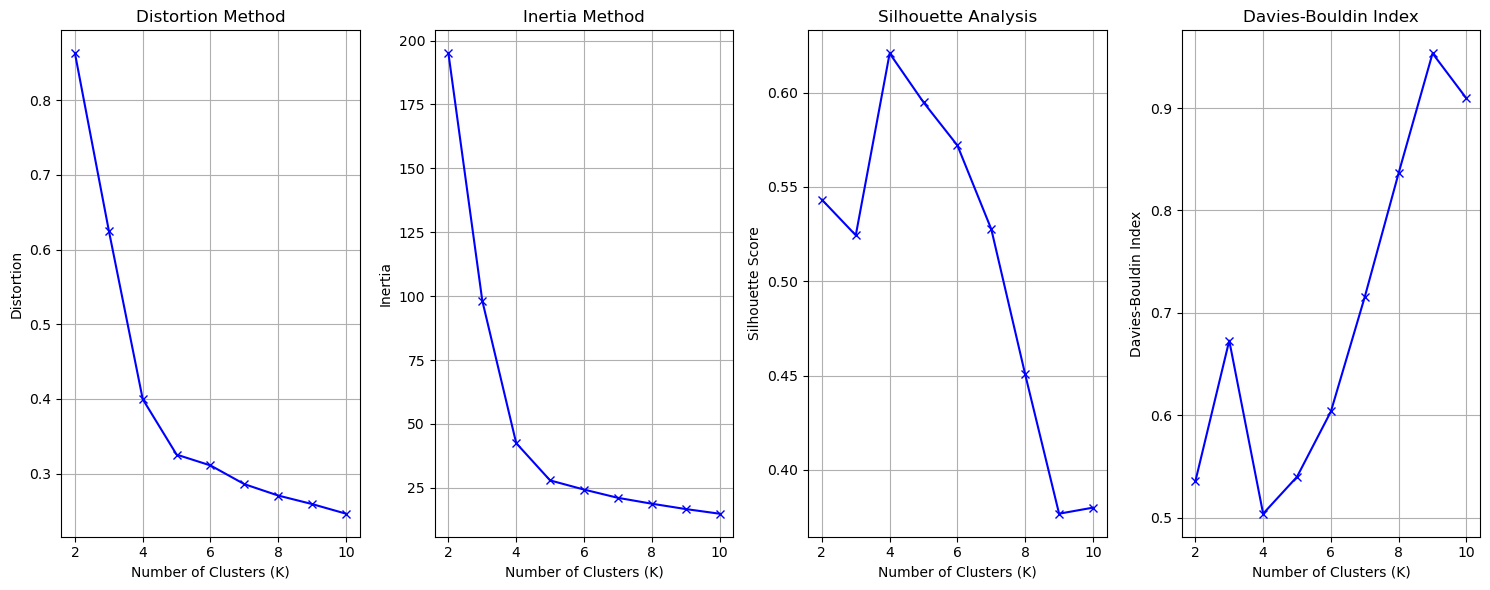

In [9]:
# Plot distortions
plt.figure(figsize=(15, 6))

plt.subplot(1, 4, 1)
plt.plot(range(2, 11), distortions, 'bx-', label='Distortion')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Distortion')
plt.title('Distortion Method')
plt.grid(True)

# Plot inertias
plt.subplot(1, 4, 2)
plt.plot(range(2, 11), inertias, 'bx-', label='Inertia')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Inertia Method')
plt.grid(True)

# Plot silhouette scores
plt.subplot(1, 4, 3)
plt.plot(K, silhouette_scores, 'bx-', label='Silhouette Score')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)

# Plot Davies-Bouldin scores
plt.subplot(1, 4, 4)
plt.plot(K, davies_bouldin_scores, 'bx-', label='Davies-Bouldin Index')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index')
plt.grid(True)

plt.tight_layout()
plt.show()

### k-means for different number of clusters

In [10]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10).fit(X_train)
kmeans.labels_

array([2, 1, 3, 1, 2, 2, 4, 3, 2, 0, 4, 3, 4, 0, 1, 1, 4, 4, 0, 4, 1, 1,
       1, 0, 3, 3, 0, 4, 0, 2, 4, 3, 2, 4, 0, 4, 1, 3, 4, 1, 2, 4, 0, 3,
       2, 3, 3, 1, 4, 4, 2, 3, 1, 3, 3, 4, 4, 0, 2, 2, 2, 2, 2, 0, 1, 0,
       0, 4, 2, 3, 4, 3, 1, 0, 0, 2, 4, 2, 1, 1, 0, 0, 2, 4, 1, 2, 2, 0,
       4, 0, 1, 3, 2, 1, 4, 0, 3, 2, 4, 4, 4, 2, 3, 2, 1, 3, 0, 3, 0, 0,
       1, 3, 2, 2, 2, 0, 4, 0, 3, 3, 0, 0, 2, 1, 1, 2, 4, 3, 2, 3, 3, 3,
       1, 1, 2, 3, 4, 0, 2, 2, 0, 1, 1, 0, 0, 0, 4, 1, 1, 3, 1, 4, 4, 0,
       3, 3, 3, 0, 2, 1], dtype=int32)

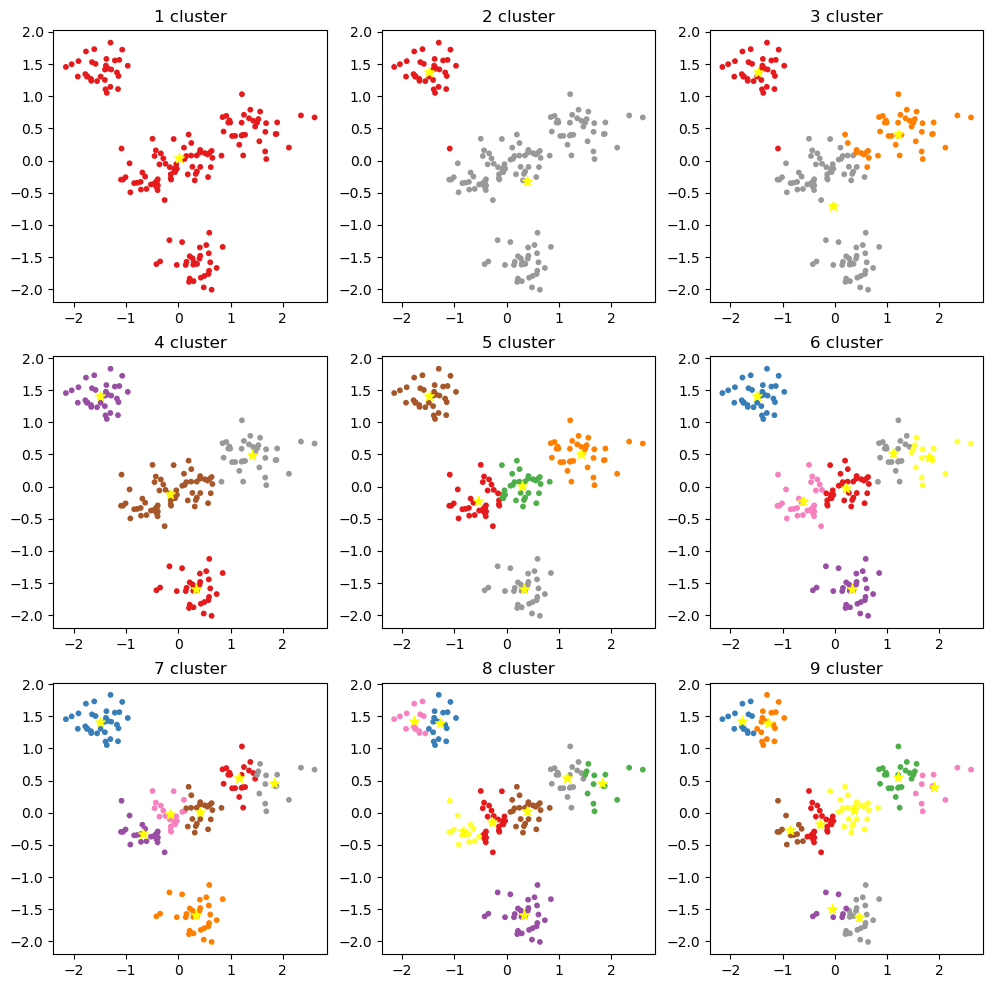

In [11]:
plt.figure(figsize=(12, 12))
for i in range(1,10):
    kmeans_2 = KMeans(n_clusters=i, random_state=0, n_init=10).fit(X_train)
    plt.subplot(3,3,i)
    plt.scatter(X_train[:, 0], X_train[:, 1], c=kmeans_2.labels_,s=10, cmap='Set1')
    plt.scatter(kmeans_2.cluster_centers_[:, 0], kmeans_2.cluster_centers_[:, 1], marker='*', s=50, c='yellow', label='centroid');
    plt.title("%i cluster" %kmeans_2.n_clusters);

Text(0.5, 1.0, 'k-means clustered data with 5 clusters')

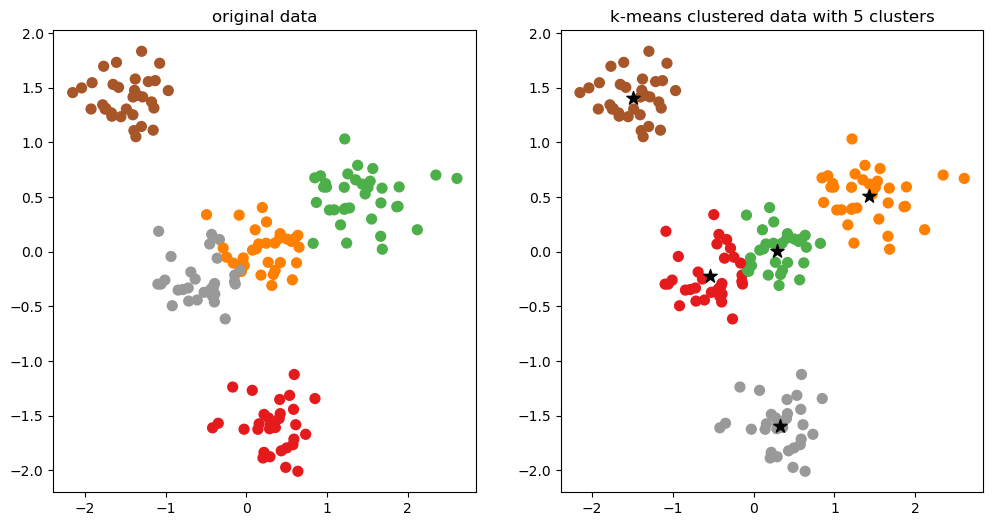

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train,s=50, cmap='Set1');
plt.title("original data")
plt.subplot(122)
plt.scatter(X_train[:, 0], X_train[:, 1], c=kmeans.labels_,s=50, cmap='Set1');
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='*', s=100, c='black', label='centroid');
plt.title("k-means clustered data with %i clusters" %kmeans.n_clusters)

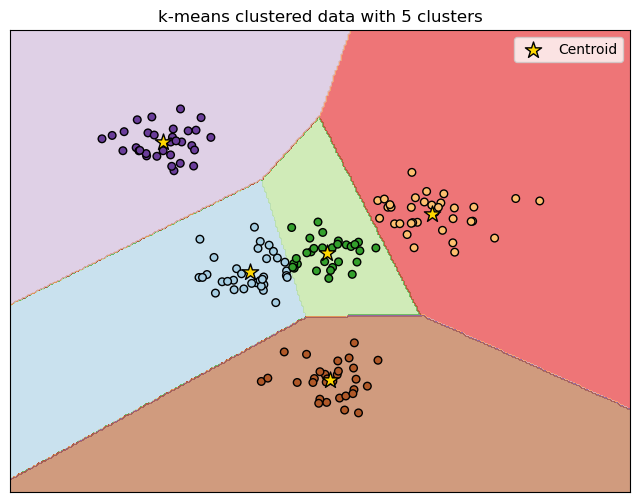

In [13]:
plot_kmeans(kmeans)

### k-means is limited to linear cluster boundaries

The fundamental model assumptions of k-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In [14]:
from sklearn.datasets import make_moons
X_2, y_2 = make_moons(200, noise=.05, random_state=0)

In [15]:
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10).fit(X_2)
kmeans.labels_

array([2, 1, 0, 3, 1, 1, 4, 4, 2, 4, 3, 0, 1, 4, 3, 4, 2, 0, 2, 3, 1, 4,
       2, 4, 3, 0, 1, 1, 0, 2, 2, 3, 4, 0, 2, 1, 0, 4, 3, 0, 4, 3, 2, 0,
       1, 3, 4, 3, 0, 4, 3, 0, 1, 3, 4, 2, 2, 4, 2, 3, 0, 3, 1, 2, 4, 3,
       3, 4, 2, 3, 4, 3, 0, 3, 4, 3, 0, 2, 2, 4, 1, 2, 4, 1, 0, 3, 4, 3,
       4, 1, 2, 2, 1, 3, 1, 1, 1, 0, 3, 0, 4, 1, 2, 4, 3, 0, 3, 3, 1, 2,
       3, 2, 2, 3, 2, 4, 2, 1, 4, 2, 2, 3, 0, 2, 0, 3, 4, 0, 4, 1, 4, 3,
       3, 0, 4, 1, 4, 3, 1, 2, 0, 0, 2, 3, 3, 4, 0, 4, 2, 0, 0, 1, 2, 2,
       4, 3, 4, 0, 2, 2, 0, 4, 2, 4, 0, 1, 2, 4, 1, 4, 2, 3, 3, 3, 0, 4,
       1, 3, 3, 2, 4, 3, 1, 1, 1, 2, 3, 4, 3, 3, 3, 2, 2, 4, 0, 3, 1, 0,
       2, 1], dtype=int32)

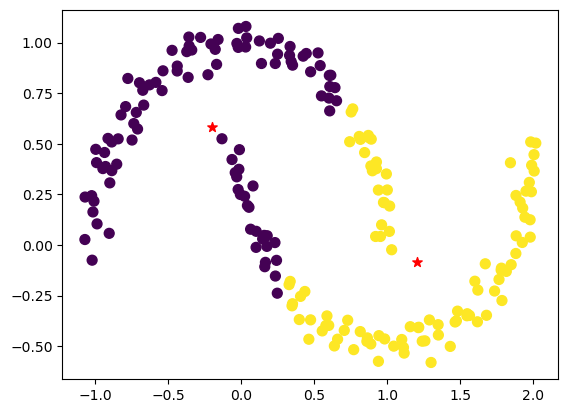

In [16]:
#model = KMeans(2, random_state=0, n_init=10).fit_predict(X_2)
model = KMeans(2, random_state=0, n_init=10).fit(X_2)
labels = model.labels_
plt.scatter(X_2[:, 0], X_2[:, 1], c=labels, s=50, cmap='viridis');
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], marker='*', s=50, c='red', label='centroid');

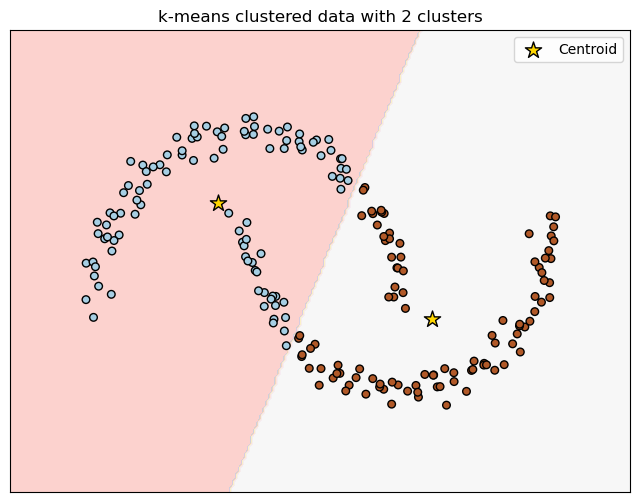

In [32]:
plot_kmeans_moons(model, X_2)

We used a kernel transformation to project the data into a higher dimension where a linear separation is possible. Using the same trick to allow k-means to discover non-linear boundaries.

One version of this kernelized k-means is implemented in Scikit-Learn within the SpectralClustering estimator. It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a k-means algorithm:

/home/lbader/.conda/envs/py310-dm-tf-cloned/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


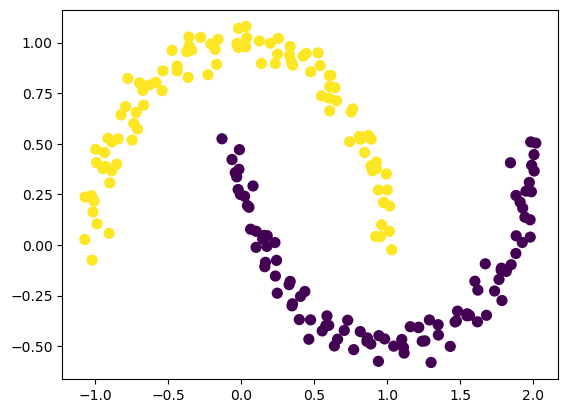

In [18]:
from sklearn.cluster import SpectralClustering
labels = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',assign_labels='kmeans').fit(X_2).labels_
plt.scatter(X_2[:, 0], X_2[:, 1], c=labels, s=50, cmap='viridis');

### k-means can be slow for large numbers of samples

Because each iteration of k-means must access every point in the dataset, the algorithm can be **relatively slow as the number of samples grows**. You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step. This is the idea behind **batch-based k-means algorithms**, one form of which is implemented in `sklearn.cluster.MiniBatchKMeans`. The interface for this is the same as for standard KMeans

## fuzzy-c-means

In fuzzy clustering, **each point has a probability of belonging to each cluster, rather than completely belonging to just one cluster as it is the case in the traditional k-means**. Fuzzy k-means specifically tries to deal with the problem where points are somewhat in between centers or otherwise ambiguous by replacing distance with probability, which of course could be some function of distance, such as having probability relative to the inverse of the distance. Fuzzy k-means uses a weighted centroid based on those probabilities.

<div>
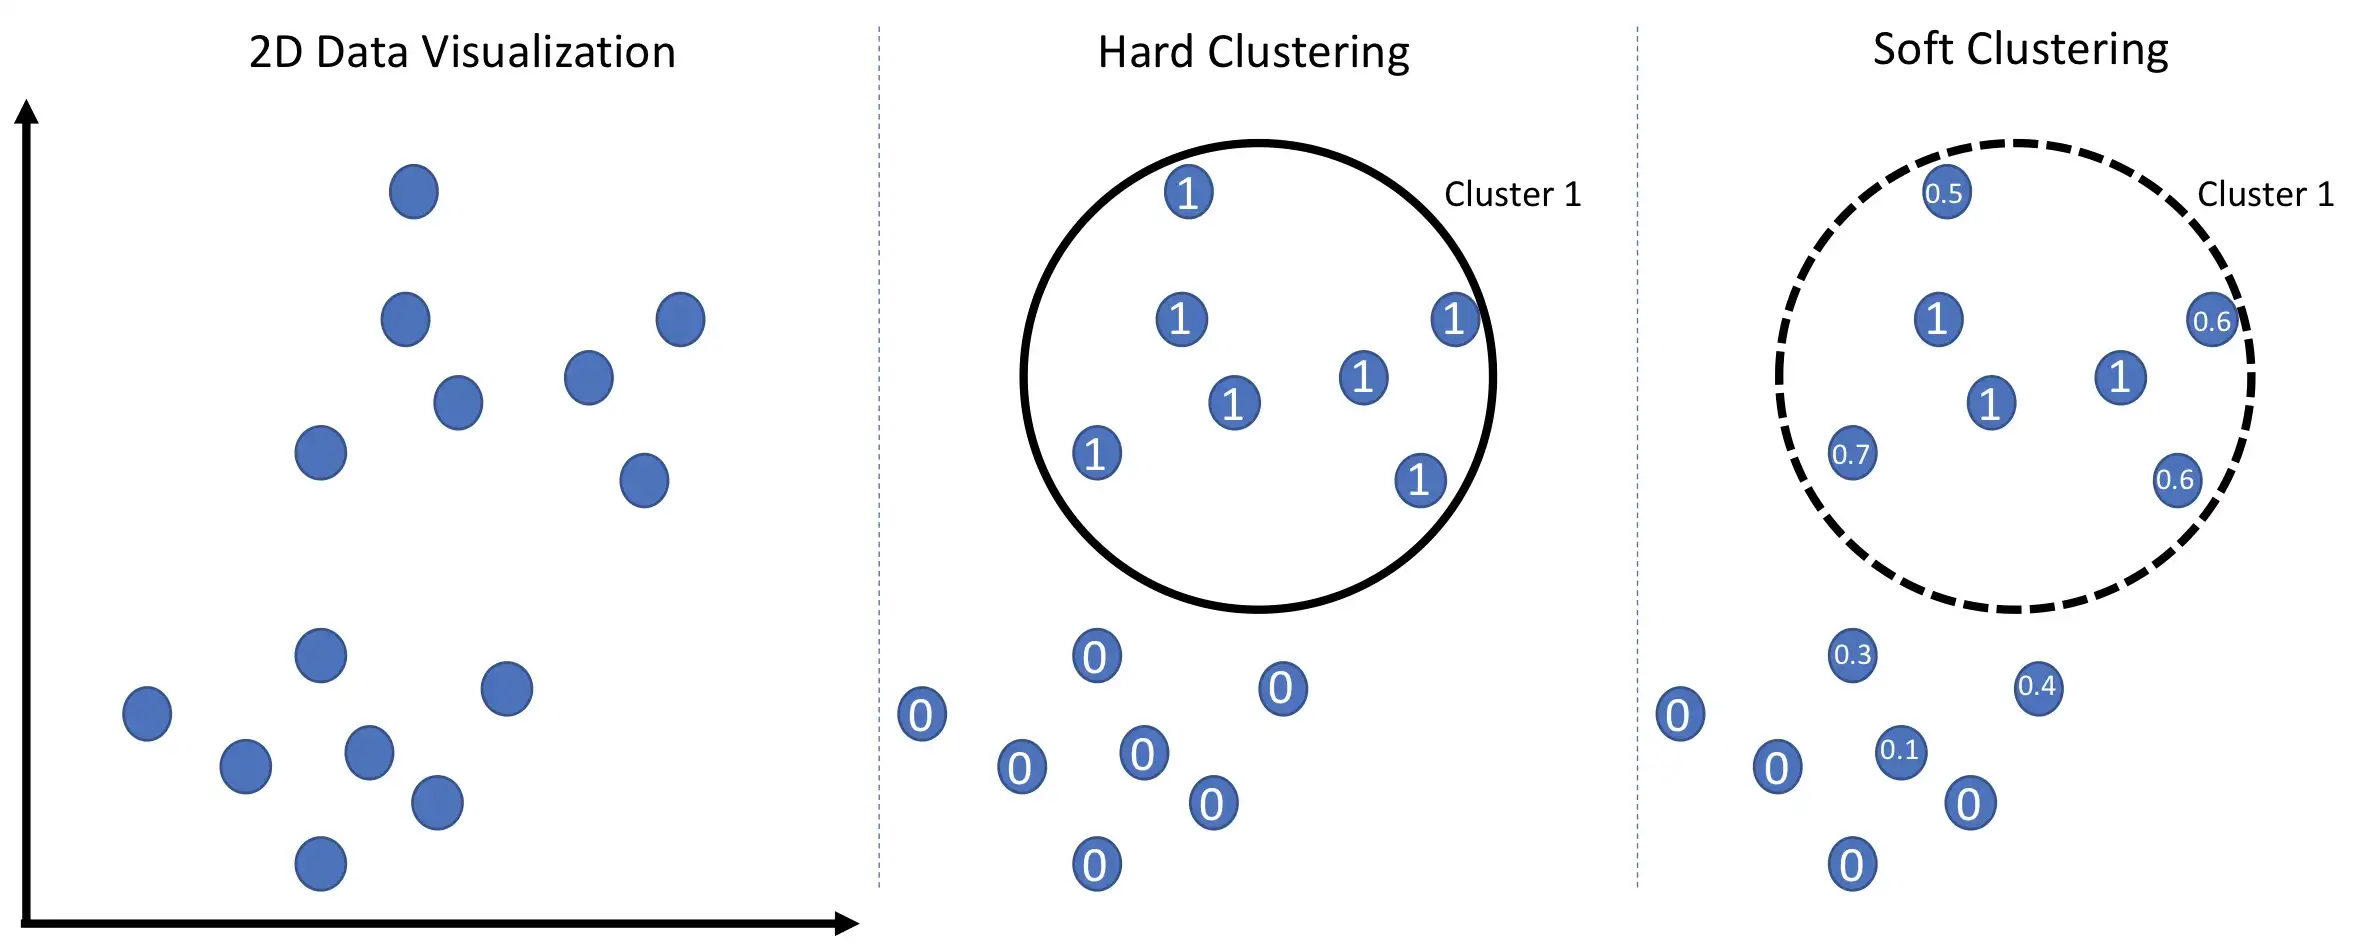
</div>


In [19]:
from fcmeans import FCM

In [20]:
# Generate data
X, y = make_blobs(n_samples=50, n_features=2, centers=3, random_state=2, cluster_std=1)

# Standardize the data
scl = StandardScaler()
X = scl.fit_transform(X)

In [21]:
# Fuzzy C-Means Clustering
fcm = FCM(n_clusters=3)  # Initialize FCM with 3 clusters
fcm.fit(X)  # Fit the model to the data
fcm_centers = fcm.centers  # Get the cluster centers
fcm_labels = fcm.predict(X)  # Discrete cluster labels
fcm_membership = fcm.u  # Membership matrix

In [24]:
# Dynamic transparency based on membership degrees
from matplotlib.colors import Normalize
max_membership = np.max(fcm_membership, axis=1)  # Maximum membership degree per point
alpha_norm = Normalize(vmin=0, vmax=1)  # Normalization for alpha
scatter_alpha = alpha_norm(max_membership)  # Normalized alpha values for transparency

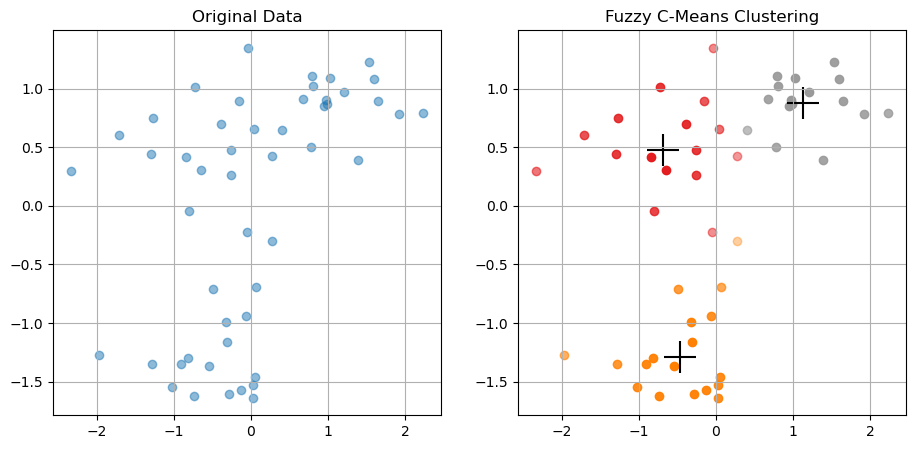

In [25]:
# Create plot
f, axes = plt.subplots(1, 2, figsize=(11, 5))

# Left plot: Points without cluster coloring
axes[0].scatter(X[:, 0], X[:, 1], alpha=0.5)
axes[0].set_title('Original Data')
axes[0].grid(True)

# Right plot: Points with cluster coloring and transparency
colors = plt.cm.Set1(fcm_labels / max(fcm_labels))  # Colors for clusters
for i in range(len(X)):
    axes[1].scatter(X[i, 0], X[i, 1], color=colors[i], alpha=scatter_alpha[i])

# Plot cluster centers
axes[1].scatter(fcm_centers[:, 0], fcm_centers[:, 1], marker="+", s=500, c="black")
axes[1].set_title('Fuzzy C-Means Clustering')
axes[1].grid(True)

plt.show()

In [26]:
fcm

FCM(n_clusters=3, max_iter=150, m=2.0, error=1e-05, random_state=None, trained=True, n_jobs=1, verbose=False, distance=<DistanceOptions.euclidean: 'euclidean'>, distance_params={}, rng=Generator(PCG64) at 0x14FD49E17AE0, u=array([[0.44594443, 0.11792305, 0.43613251],
       [0.86150108, 0.08636846, 0.05213046],
       [0.86385708, 0.07448482, 0.0616581 ],
       [0.04008401, 0.9418312 , 0.0180848 ],
       [0.29200417, 0.61158374, 0.09641209],
       [0.87774185, 0.04800997, 0.07424819],
       [0.14418607, 0.80663448, 0.04917944],
       [0.00709389, 0.00310357, 0.98980254],
       [0.08038907, 0.88752751, 0.03208342],
       [0.0041087 , 0.00200082, 0.99389049],
       [0.74881177, 0.15428296, 0.09690527],
       [0.06720923, 0.88828003, 0.04451074],
       [0.04571201, 0.01667187, 0.93761612],
       [0.05850947, 0.0207525 , 0.92073803],
       [0.04821158, 0.02570212, 0.9260863 ],
       [0.00759068, 0.00326699, 0.98914233],
       [0.06433245, 0.89377315, 0.04189439],
       [0.04

## DBSCan (Density Based Clustering)

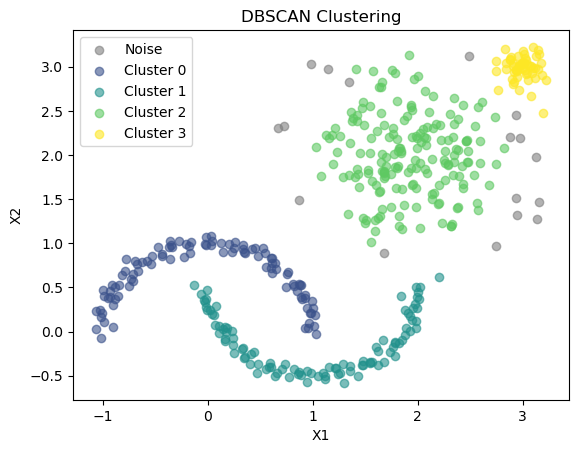

In [27]:
from sklearn.cluster import DBSCAN
# Generate a sample dataset with overlapping clusters
X1, y1 = make_moons(n_samples=200, noise=0.05, random_state=0)
X2, y2 = make_blobs(n_samples=200, centers=[[2, 2]], cluster_std=0.5, random_state=0)
X3, y3 = make_blobs(n_samples=50, centers=[[3, 3]], cluster_std=0.1, random_state=0)
# Combine the data points into a single dataset
X = np.concatenate((X1, X2, X3), axis=0)

# DBSCAN clustering
def dbscan_clustering(X, eps, min_samples):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    y_pred = model.fit_predict(X)
    return y_pred

# Function to plot the data points and clusters
def plot_clusters(X, y):
    # Generate a color map based on the unique labels
    unique_labels = np.unique(y)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

    # Plot each cluster with a unique color
    for i, label in enumerate(unique_labels):
        if label == -1:
            # Plot noise with a gray color
            plt.scatter(X[y == label, 0], X[y == label, 1], color='gray', label='Noise', alpha=0.6)
        else:
            # Plot each cluster with a specific color
            plt.scatter(X[y == label, 0], X[y == label, 1], color=colors[i], label=f'Cluster {label}', alpha=0.6)

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('DBSCAN Clustering')
    plt.legend()

# Parameters for DBSCAN
eps = 0.25  # maximum distance between two data points (neighborhood size)
min_samples = 6  # minimum number of data points required in a neighborhood

# Perform DBSCAN clustering
y_pred = dbscan_clustering(X, eps, min_samples)

# Plot the results
plot_clusters(X, y_pred)

plt.show()


## Hierarchical Clustering (Agglomerative / bottom up)

[(0, 0), (1, 0), (2, 0), (3, 0), (4, 2), (5, 2), (6, 0), (7, 3), (8, 1), (9, 2), (10, 2), (11, 0), (12, 1), (13, 1), (14, 0), (15, 1), (16, 0), (17, 1), (18, 0), (19, 2)]
[array([0.51471524, 0.6782106 ]), array([0.1130383 , 0.76181579]), array([0.89118219, 0.65266549]), array([0.07103606, 0.0871293 ])]


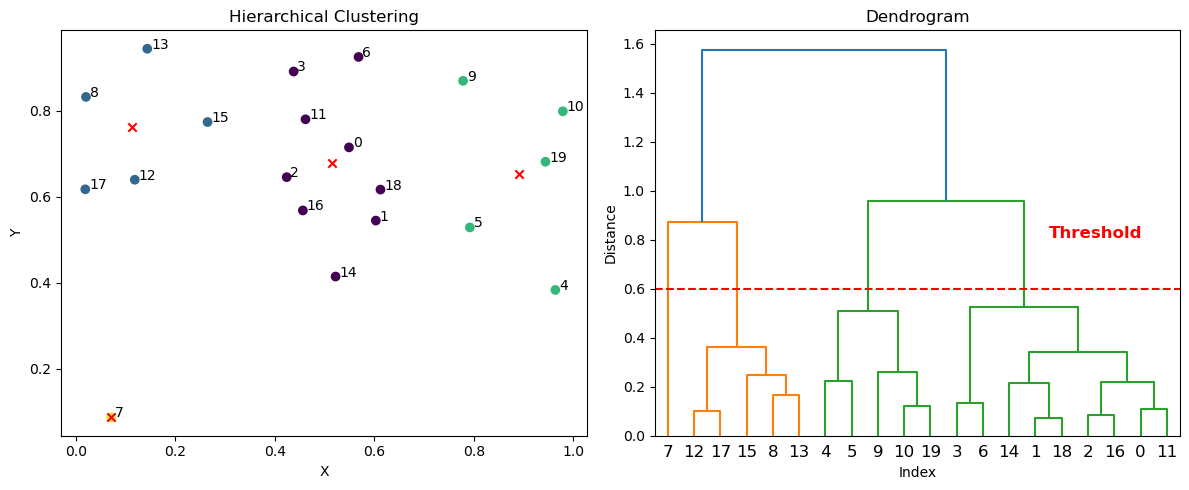

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Generate random data points for clustering
np.random.seed(0)
X = np.random.rand(20, 2)  # Example dataset with 20 points

# Perform hierarchical clustering with AgglomerativeClustering
threshold = 0.6#1.4#0.6  # Distance threshold for clustering
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=threshold)
clustering.fit(X)

# Get cluster labels and cluster centers
labels = clustering.labels_

# Combine point numbers and labels for printing
point_labels = [(i, labels[i]) for i in range(len(labels))]

print(point_labels)  # Printing points with their labels

centroids = []
for label in np.unique(labels):
    centroid = X[labels == label].mean(axis=0)
    centroids.append(centroid)

print(centroids)

# Calculate linkage matrix
linked = linkage(X, method='ward')

# Plot scatter and dendrogram in a subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot with cluster labels and centroids
ax1.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
for i, (x, y) in enumerate(X):
    ax1.text(x + 0.0075, y, f'{i}', color='black', fontsize=10)  # Point number next to the point
ax1.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], marker='x', color='red')
ax1.set_title('Hierarchical Clustering')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# Dendrogram
dendrogram_data = dendrogram(linked, ax=ax2)
ax2.axhline(y=threshold, color='r', linestyle='--')  # Mark the threshold level
# Place the threshold label on the right side of the entire plot (outside the dendrogram)
ax2.text(0.75, 0.5, 'Threshold', verticalalignment='center', color='red', fontsize=12, weight='bold', transform=ax2.transAxes)  # Label the threshold line

ax2.set_title('Dendrogram')
ax2.set_xlabel('Index')
ax2.set_ylabel('Distance')

plt.tight_layout()
plt.show()


In [29]:
print(linked)

[[ 1.         18.          0.07265268  2.        ]
 [ 2.         16.          0.08400022  2.        ]
 [12.         17.          0.10195016  2.        ]
 [ 0.         11.          0.10907128  2.        ]
 [10.         19.          0.12240998  2.        ]
 [ 3.          6.          0.13477076  2.        ]
 [ 8.         13.          0.16648482  2.        ]
 [14.         20.          0.21590768  3.        ]
 [21.         23.          0.21932584  4.        ]
 [ 4.          5.          0.2252094   2.        ]
 [15.         26.          0.24898352  3.        ]
 [ 9.         24.          0.2589075   3.        ]
 [27.         28.          0.34355751  7.        ]
 [22.         30.          0.36221344  5.        ]
 [29.         31.          0.50854768  5.        ]
 [25.         32.          0.52336257  9.        ]
 [ 7.         33.          0.87270275  6.        ]
 [34.         35.          0.95671285 14.        ]
 [36.         37.          1.57517686 20.        ]]


# Metrics

## Euclidean distance & Mahalanobis distance

The Mahalanobis distance is a metric that measures how far a point is from a distribution, taking into account the correlations between variables in that dataset. It is especially useful when variables have different scales or correlations.

Distance between Point 1 and Point 2:
Euclidean Distance: 5.66
Mahalanobis Distance: 3.92

Distance between Point 3 and Point 4:
Euclidean Distance: 2.83
Mahalanobis Distance: 8.58


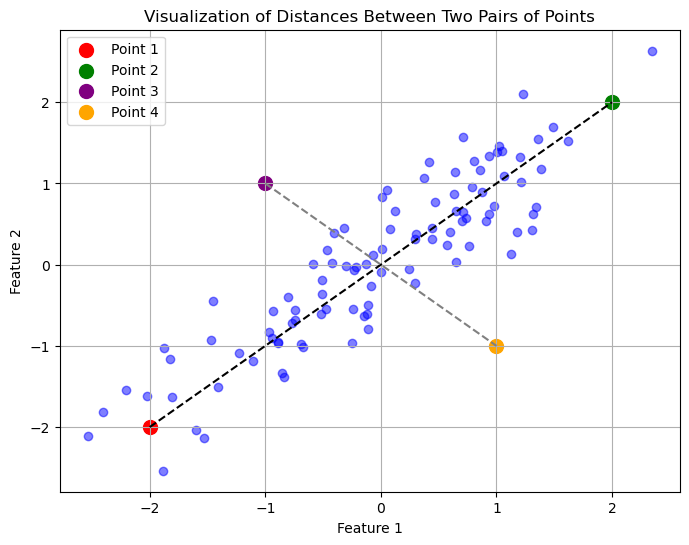

In [30]:
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler


# 1. Generate a dataset with highly correlated values
np.random.seed(0)
mean = [0, 0]  # Mean values for the normal distribution
cov_matrix = np.array([[1, 0.9], [0.9, 1]])  # Covariance matrix with strong correlation
data = np.random.multivariate_normal(mean, cov_matrix, 100)  # Generate 100 data points

# 2. Select two random points from the dataset
point_1 = np.array([-2, -2])
point_2 = np.array([2, 2])

# 3. Add another pair of random points
point_3 = np.array([-1, 1])
point_4 = np.array([1, -1])

# 4. Compute distances for Pair 1 (Point 1 and Point 2)

# Euclidean distance
euclidean_distance_1 = np.linalg.norm(point_1 - point_2)
# Mahalanobis distance (scale the data)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
point_1_scaled = scaler.transform([point_1])
point_2_scaled = scaler.transform([point_2])
# Mahalanobis distance (compute inverse of covariance matrix)
inv_cov_matrix = np.linalg.inv(np.cov(data.T))  # Inverse of the covariance matrix
mahalanobis_distance_1 = cdist(point_1_scaled, point_2_scaled, metric='mahalanobis', VI=inv_cov_matrix)[0][0]

# 5. Compute distances for Pair 2 (Point 3 and Point 4)

# Euclidean distance
euclidean_distance_2 = np.linalg.norm(point_3 - point_4)
# Mahalanobis distance (scale the data)
point_3_scaled = scaler.transform([point_3])
point_4_scaled = scaler.transform([point_4])
# Mahalanobis distance (compute inverse of covariance matrix)
mahalanobis_distance_2 = cdist(point_3_scaled, point_4_scaled, metric='mahalanobis', VI=inv_cov_matrix)[0][0]

# Print distances for Pair 1
print(f"Distance between Point 1 and Point 2:")
print(f"Euclidean Distance: {euclidean_distance_1:.2f}")
print(f"Mahalanobis Distance: {mahalanobis_distance_1:.2f}")
print("")

# Print distances for Pair 2
print(f"Distance between Point 3 and Point 4:")
print(f"Euclidean Distance: {euclidean_distance_2:.2f}")
print(f"Mahalanobis Distance: {mahalanobis_distance_2:.2f}")

# Visualization of the points and distances
plt.figure(figsize=(8, 6))

# Original data points
plt.scatter(data[:, 0], data[:, 1], color='blue', alpha=0.5)

# First pair of points (Point 1 and Point 2)
plt.scatter(point_1[0], point_1[1], color='red', label='Point 1', s=100)
plt.scatter(point_2[0], point_2[1], color='green', label='Point 2', s=100)

# Second pair of points (Point 3 and Point 4)
plt.scatter(point_3[0], point_3[1], color='purple', label='Point 3', s=100)
plt.scatter(point_4[0], point_4[1], color='orange', label='Point 4', s=100)

# Draw lines representing distances
plt.plot([point_1[0], point_2[0]], [point_1[1], point_2[1]], color='black', linestyle='--')
plt.plot([point_3[0], point_4[0]], [point_3[1], point_4[1]], color='gray', linestyle='--')

plt.title("Visualization of Distances Between Two Pairs of Points")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.grid(True)
plt.show()


## Euclidean distance & Manhattan distance

The Manhattan distance, also known as the L1 norm or taxicab distance, is a metric used to measure the distance between two points in a grid-based system (like a city grid), where movement is restricted to horizontal and vertical directions (not diagonally).

Manhattan Distance: 20
Euclidean Distance: 14.142135623730951


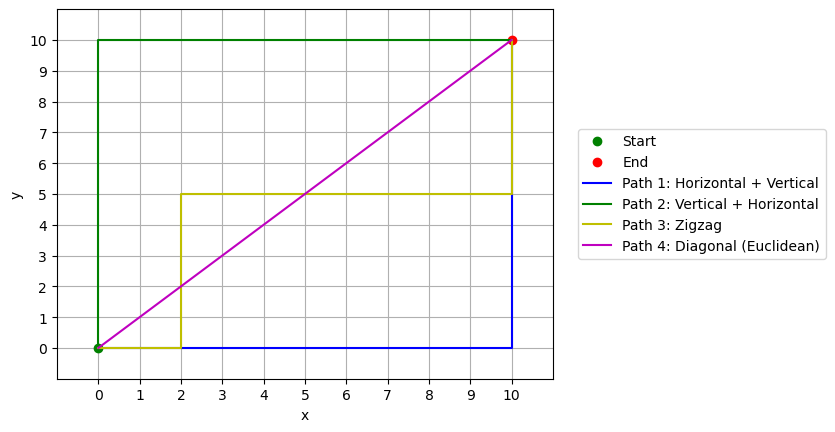

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate Manhattan distance
def manhattan_distance(p1, p2):
    return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

# Function to calculate Euclidean distance
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Start and end points
start = (0, 0)
end = (10, 10)

# Calculate Manhattan and Euclidean distances
manhattan_dist = manhattan_distance(start, end)
euclidean_dist = euclidean_distance(start, end)

# Visualization of paths and distances
fig, ax = plt.subplots()

# Grid setup for visualization
ax.set_xlim(-1, 11)
ax.set_ylim(-1, 11)
ax.set_xticks(range(0, 11, 1))  # Set ticks from 0 to 10 for x-axis
ax.set_yticks(range(0, 11, 1))  # Set ticks from 0 to 10 for y-axis
ax.grid(True)

# Plot start and end points
ax.plot(start[0], start[1], 'go', label='Start')  # Start point (green circle)
ax.plot(end[0], end[1], 'ro', label='End')       # End point (red circle)

# Draw three Manhattan paths (rectilinear movement)
# Path 1: Horizontal first, then vertical
way_1 = [(0, 0), (10, 0), (10, 10)]  # Horizontal to x=10, then vertical to y=10
ax.plot([point[0] for point in way_1], [point[1] for point in way_1], 'b-', label='Path 1: Horizontal + Vertical')

# Path 2: Vertical first, then horizontal
way_2 = [(0, 0), (0, 10), (10, 10)]  # Vertical to y=10, then horizontal to x=10
ax.plot([point[0] for point in way_2], [point[1] for point in way_2], 'g-', label='Path 2: Vertical + Horizontal')

# Path 3: Zigzag movement
way_3 = [(0, 0), (2, 0), (2, 2), (2, 5), (10, 5), (10, 10)]  # Zigzag path to (10, 10)
ax.plot([point[0] for point in way_3], [point[1] for point in way_3], 'y-', label='Path 3: Zigzag')

# Path 4: Diagonal (Euclidean distance)
way_4 = [(0, 0), (10, 10)]  # Direct diagonal path
ax.plot([point[0] for point in way_4], [point[1] for point in way_4], 'm-', label='Path 4: Diagonal (Euclidean)')

# Add labels and legend
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0.)

# Display calculated distances
print(f"Manhattan Distance: {manhattan_dist}")
print(f"Euclidean Distance: {euclidean_dist}")

# Show the visualization
plt.show()
